Importing Libraries to be used in the notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

# libraries for NLP
from nltk.corpus import stopwords
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# libraries to check model metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score

from xgboost import XGBClassifier

# Loading Dataset

In [2]:
# Importing train and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_with_no_labels.csv')
display(train_df.head())
display(test_df.head())


,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


# Exploratory Data Analysis 

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


The dataset contains three features
- the dataset consist of `15819` rows
- there seems to be no null values


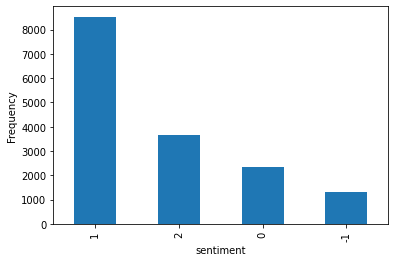

In [4]:
train_df.sentiment.value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xlabel('sentiment');

Most tweets support the man-made climate change which is represented by `1` while we have a fewer anti-climate change tweets

# Data Cleaning and Wrangling 

### Creating a function to clean the `message`

In [5]:
# sentiment_list
sentiment_list = ['Neutral', 'Anti-Climate', 'Pro-Climate','News-Fact']

In [6]:
# # creating a function to stem each words
stemmer = SnowballStemmer('english')
# creating a function to lemmatize each words
lemmatizer = WordNetLemmatizer()

In [7]:
# creating a function
def cleaning(tweet):
    pattern = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    rem_link = re.sub(pattern, '', tweet)
    rem_punct = re.sub(r'[^a-zA-Z ]', '', rem_link)
    rem_punct = re.sub(r'RT', '', rem_punct)
    word_split = rem_punct.lower().split()
    stops = set(stopwords.words("english"))
    without_stop_sent = ' '.join([t for t in word_split if t not in stops])
    return without_stop_sent

train_df['cleaned_tweet'] = train_df.message.apply(cleaning)

In [8]:
def stemmer_fn(words, stemmer):
    word_split = set(words.split())
    return ' '.join([stemmer.stem(word) for word in word_split])

train_df['stem_tweet'] = train_df.cleaned_tweet.apply(stemmer_fn, args=(stemmer, ))

In [9]:
def lemmatizer_fn(words, lemmatizer):
    word_split = set(words.split())
    return ' '.join([lemmatizer.lemmatize(word) for word in word_split])

train_df['lemma_tweet'] = train_df['cleaned_tweet'].apply(lemmatizer_fn, args=(lemmatizer, ))

In [10]:
train_df.head()

,sentiment,message,tweetid,cleaned_tweet,stem_tweet,lemma_tweet
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,epa wait doesnt think global carbon chief caus...,epa wait doesnt think global carbon chief caus...
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming,global evid like anthropogen lack warm,global evidence like anthropogenic lack warming
2,2,RT @RawStory: Researchers say we have three ye...,698562,rawstory researchers say three years act clima...,rawstori year chang research three act late sa...,rawstory year change researcher three act late...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired pivotal year war climate ch...,chang pivot war year todayinmak wire climat,change pivotal war year todayinmaker wired cli...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,soynoviodetodas racist sexist climate change d...,lead sexist chang poll electionnight soynoviod...,leading sexist change poll electionnight soyno...


In [ ]:
# Downsample majority
not_spam_downsampled = resample(not_spam,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=len(spam), # match number in minority class
                          random_state=27) # reproducible results

# Combine downsampled majority class with minority class
downsampled = pd.concat([not_spam_downsampled, spam])

# Check new class counts
downsampled['spam'].value_counts()

In [11]:
# vectorize
vectorizer = CountVectorizer(analyzer = "word",
#                              min_df=2,
#                              max_df = 0.5,
#                              ngram_range=(1, 5),
                             max_features = 19000) 

In [12]:
reviews_vect = vectorizer.fit_transform(train_df['lemma_tweet'])

In [13]:
train_data_features = reviews_vect.toarray() # for fast fitting of our dataset
train_data_features.shape

(15819, 5000)

In [14]:
y = np.array(train_df['sentiment'])
X = train_data_features

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [15]:
def modelling(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, coln_index=None):
    model.fit(X_train, y_train)
    pred_lm = model.predict(X_test)
    # Plotting confusion matrix
    cm = confusion_matrix(y_test, pred_lm)
    cm_df = pd.DataFrame(cm, index = sentiment_list, columns = sentiment_list)
    cr_df = pd.DataFrame(classification_report(y_test, pred_lm, target_names=sentiment_list, output_dict=True))
    
    #Plotting the confusion matrix
    plt.figure(figsize=(10,5))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
    print('Confusion Matrix')
    display(cm_df)
    print('Classification Report')
    display(cr_df)
    
    return cm_df, cr_df

[LibLinear]

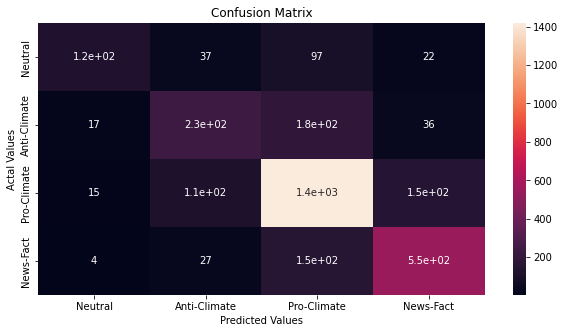

Confusion Matrix


,Neutral,Anti-Climate,Pro-Climate,News-Fact
Neutral,123,37,97,22
Anti-Climate,17,226,185,36
Pro-Climate,15,110,1419,147
News-Fact,4,27,153,546


Classification Report


,Neutral,Anti-Climate,Pro-Climate,News-Fact,accuracy,macro avg,weighted avg
precision,0.773585,0.565000,0.765372,0.727031,0.731353,0.707747,0.727866
recall,0.440860,0.487069,0.839148,0.747945,0.731353,0.628756,0.731353
f1-score,0.561644,0.523148,0.800564,0.737340,0.731353,0.655674,0.724226
support,279.000000,464.000000,1691.000000,730.000000,0.731353,3164.000000,3164.000000


In [16]:
# create logistic regression model instance
lm = LogisticRegression(C=2, penalty='l2', solver='liblinear', verbose=1)
cm_df, cr_df = modelling(lm,  coln_index=sentiment_list)